# Training data generation

This tutorial leads through the full process of training data generation for the detection of sarcomere Z-bands, M-bands, sarcomere orientation maps, sarcomere masks, and cell masks. SarcAsM comes with a capable generalist model pretrained on a diverse data set (different cells, labeling, microscopes, magnifications) that likely works for most applications. For special data, users can create their own data set and train their own model or fine-tune our generalist model. Details on training see [tutorial here](tutorial_training_sarcomere_analysis.ipynb).

Training data is generated in a multistep process:
1. Manual annotation of Z-bands in a set of training images
2. Training of a U-Net to predict Z-bands more robustly for further processing steps
3. Generation of preliminary M-band masks, sarcomere orientation maps, and sarcomere masks
4. Manual curation of M-band masks to remove false-positives and false-negatives (see SI Fig. S4b)
5. Generation of final sarcomere orientation maps and sarcomere masks based on corrected M-band masks

## 1. Creation of training data set and annotation of Z-bands

For training a custom model, we recommend compiling a representative training dataset of 20-50 images. If the images have multiple channels or frames, they should be transformed to single 1-channel grayscale images. These data should be representative of the full data set and sample possible morphologies.



### Generate small patches from large images or stacks (optional)

To enhance training efficiency and speed up annotation processes, randomly crop patches from large images or stacks. This ensures a representative selection of samples for training. After generation, replace the original images in dir_images with the patches.

In [2]:
import glob
import os
import tifffile
import numpy as np

# set paths of directories
dir_images = '../../training_data_tutorial/image/'
dir_zbands_manual = '../../training_data_tutorial/zbands_manual/'

# create directories for patches
dir_images_patches = '../../training_data_tutorial/image_patch/'
os.makedirs(dir_images_patches, exist_ok=True)

# list images
list_images = glob.glob(dir_images + '*.tif')

# patch size and number per image
patch_size = (512, 512)
n_patches = 6

# iterate through images and create random patches
np.random.seed(42)
for image in list_images:
    data = tifffile.imread(image)
    x_patches, y_patches = np.random.randint(0, data.shape[0]-patch_size[0], size=n_patches), np.random.randint(0, data.shape[1]-patch_size[1], size=n_patches)
    for x, y in zip(x_patches, y_patches):
        patch = data[y:y+patch_size[1], x:x+patch_size[0]]
        name = dir_images_patches + os.path.splitext(os.path.basename(image))[0] + f'_patch_{y}_{x}.tif'
        tifffile.imwrite(name, patch)

### Annotation of Z-bands in images

For annotation of sarcomere Z-bands, an application on tablet equipped with a pen, or a bio-image viewer (e.g., ImageJ or napari) can be used to create binary mask of sarcomere Z-bands. Here we demonstrate the annotation using a custom script built in [napari](https://napari.org/stable/) included in our package [bio-image-unet](https://github.com/danihae/bio-image-unet). It allows for the iteration through all images. When an annotation is finished, press "Save and Next" to proceed to the next image.

In [7]:
from bio_image_unet.utils.image_annotator import ImageAnnotator

# set paths of directories
dir_images = '../../training_data_tutorial/image/'
dir_zbands_manual = '../../training_data_tutorial/zbands_manual/'

# Annotate all images, press "Save and Next" when image is finished
annotator = ImageAnnotator(
    folder_images=dir_images,
    output_folder=dir_zbands_manual,
    label_name='Z-bands',
    brush_size=4
)

### Annotation of cell mask in images

Training data for the prediction of cell masks (1 = cell, 0 = background) can be created in the same manner.

In [ ]:
# set paths of directories
dir_images = '../../training_data_tutorial/image/'
dir_cell_mask = '../../training_data_tutorial/cell_mask/'

# Annotate all images, press "Save and Next" when image is finished
annotator = ImageAnnotator(
    folder_images=dir_images,
    output_folder=dir_cell_mask,
    label_name='Cell mask',
    brush_size=4
)

## Training of U-Net to predict Z-bands

The U-Net model learns to predict Z-bands by extracting generalized features from manually annotated training data while compensating for annotation inconsistencies through extensive data augmentation. By exposing the network to randomized variations of the training images, it develops robust pattern recognition capabilities that outperform manual annotations in precision and consistency. This approach reduces human-introduced errors like uneven line thickness, missed low-contrast regions, and accidental gaps, producing more reliable Z-band masks for downstream analysis steps.

For the different options for processing and augmentation (add noise, blur, adjust contrast, ...) see docstring or [API reference](../autoapi/bio_image_unet/unet/data/index.html).

In [ ]:
import bio_image_unet.unet as unet

# directories with images and z-band masks, see above
dir_images = '../../training_data_tutorial/image/'  # adjust paths accordingly
dir_zbands_manual = '../../training_data_tutorial/zbands_manual/'

# temp folder
dir_temp = '../../training_data_tutorial/temp/'
os.makedirs(dir_temp, exist_ok=True)

# prepare and process training data
data = unet.DataProcess([dir_images, dir_zbands_manual], aug_factor=10, data_path=dir_temp)

### Set training parameters and train

For different training parameters, check the docstring `print(unet.Trainer.__doc__)` or [API reference](../autoapi/bio_image_unet/unet/train/index.html).

In [ ]:
# set training parameters
trainer = unet.Trainer(dataset=data, num_epochs=100, loss_function='BCEDice')

# start training
trainer.start()

After training is completed, the model parameters `model.pt` are stored in the `folder_temp`.

## 3. Generation of preliminary training targets

Next, preliminary training targets (M-band mask, sarcomere orientation map, sarcomere mask) are created based on the Z-band masks predicted by U-Net using a custom double wavelet analysis.

All steps are wrapped in a `TrainingDataGenerator` class, details see [API reference](../autoapi/sarcasm/training_data_generator/index.html).

In [ ]:
# define dir paths for targets
dir_training_data = '../../training_data_tutorial/'  # modify path if needed
dir_images = dir_training_data + '/image/'  # this directory contains all images
dir_zbands = dir_training_data + '/zbands/'
dir_zbands_prelim = dir_training_data + '/zbands_prelim/'
dir_mbands = dir_training_data + '/mbands/'
dir_orientation = dir_training_data + '/orientation/'
dir_sarcomere_mask = dir_training_data + '/sarcomere_mask/'

# create dirs
for dir in [dir_zbands, dir_zbands_prelim, dir_mbands, dir_orientation, dir_sarcomere_mask]:
    os.makedirs(dir, exist_ok=True)

# define dict with output dirs for targets
output_dirs = {'zbands': dir_zbands, 'zbands_prelim': dir_zbands_prelim, 'mbands': dir_mbands,
               'orientation': dir_orientation, 'sarcomere_mask': dir_sarcomere_mask}

In [ ]:
# manually iterate through each training image

image_paths = glob.glob(dir_images + '*.tif')

i = 0

image_path_i = image_paths[i]
print(image_path_i)

In [ ]:
from sarcasm import TrainingDataGenerator

# initialize image (if pixel size is not in metadata of tiff file, specify it as argument)
generator_i = TrainingDataGenerator(image_path=image_path_i, output_dirs=output_dirs)

In [ ]:
# detect Z-bands using U-Net
model_path = '../../models/model_z_bands_unet.pt'  # adapt path to your own model if needed
generator_i.predict_zbands(model_path=model_path, patch_size=(1024, 1024))  # decrease patch size if memory issues occur

In [158]:
import torch

# run wavelet analysis -> adapt parameters for each file for optimal results
device = torch.device('mps')  # 'mps' for Apple Silicon (M1,...), 'cpu' for CPU, 'cuda' for Nvidia GPU
score_threshold = 0.25
minor, major = (0.2, 1)  # minor and major axis lengths of wavelet kernel
len_lims = (1.4, 2.7)
len_step = 0.05
orient_step = 5

generator_i.wavelet_analysis(device=device, score_threshold=score_threshold,
                                 minor=minor, major=major, len_lims=len_lims,
                                 len_step=len_step, orient_step=orient_step)

# create sarcomere mask

dilation_radius = 0.2  # dilation radius in µm

generator_i.create_sarcomere_mask(dilation_radius=dilation_radius)

# create orientation angle map

generator_i.create_orientation_map()

# smooth orientation angle map
window_size = 5  # window size in pixels
generator_i.smooth_orientation_map(window_size=window_size)

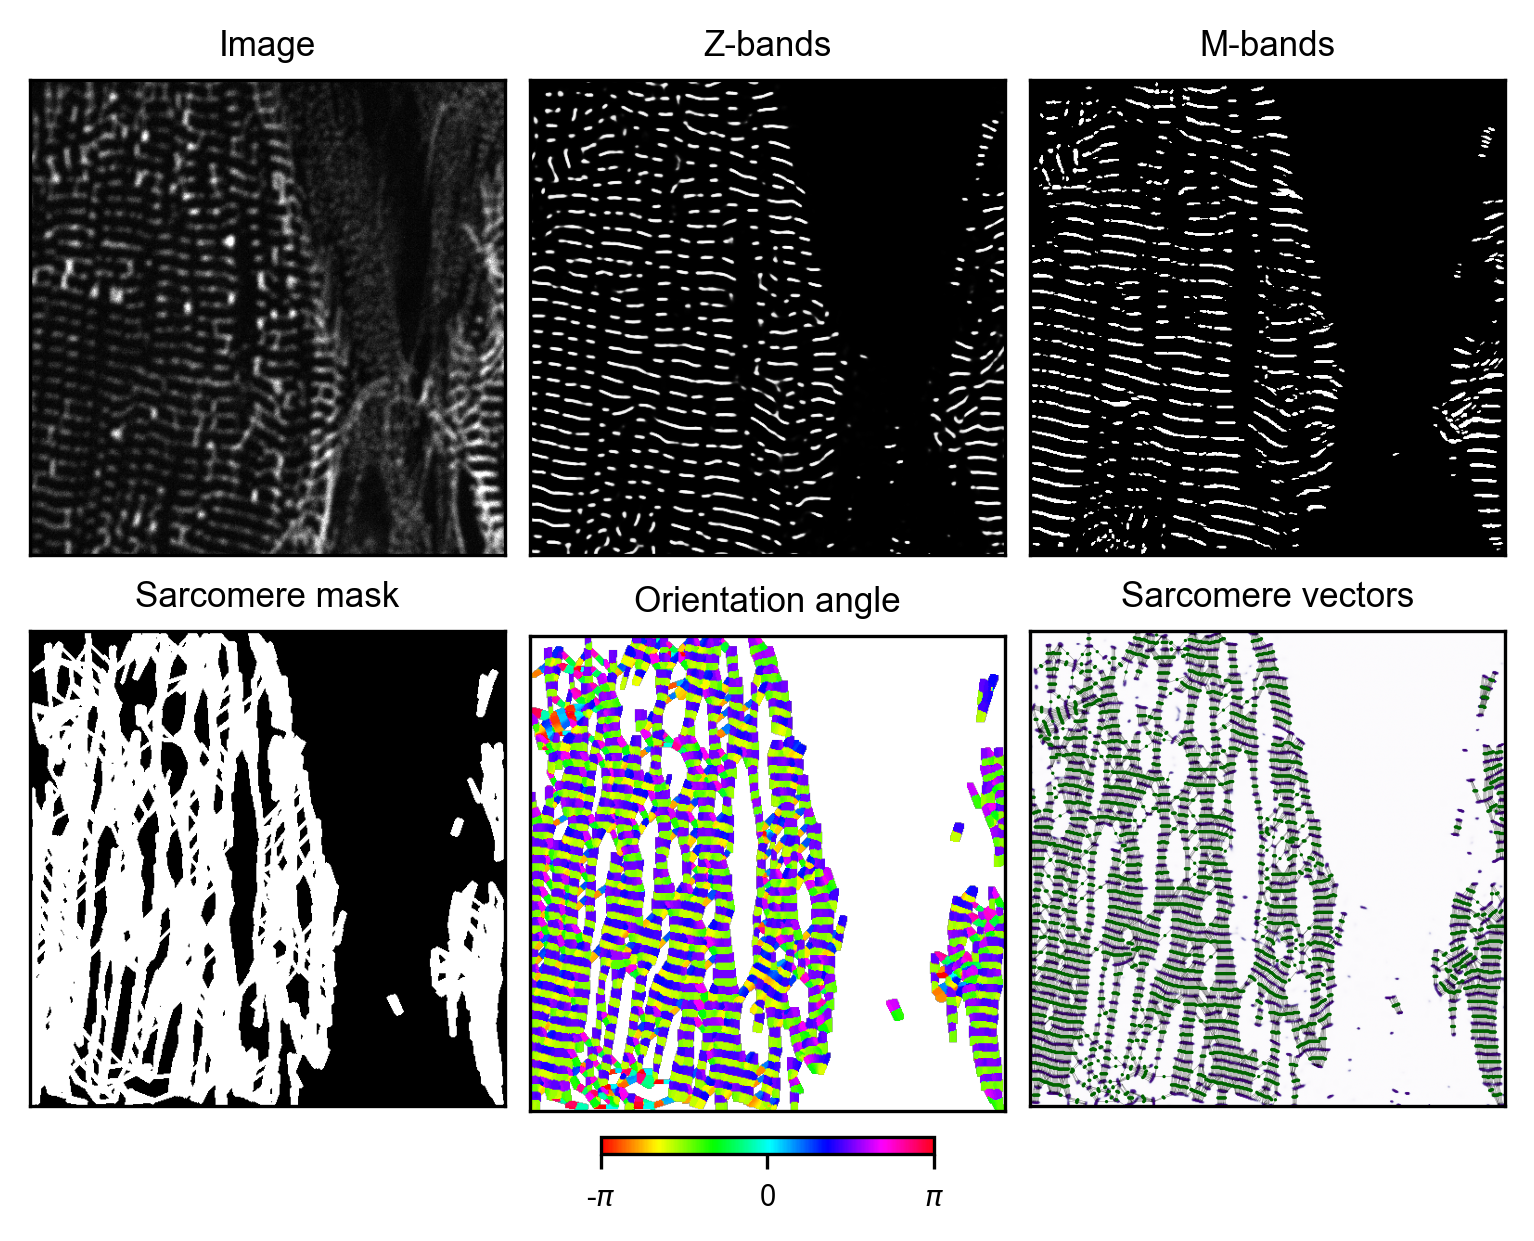

In [159]:
# plot result for image i -> iteratively optimize parameters for optimal output
generator_i.plot_results()

## 4. Manual curation of M-band masks

The Z-band masks created by the double wavelet analysis are often faulty with many false-positives. The resulting sarcomere vectors, and accordingly the orientation map and the sarcomere mask are thus imprecise. For optimal training data quality, the M-bands need to be manually corrected for each image.


In [6]:
import napari

# manually correct M-bands in Napari (use eraser tool to remove false-positives)
viewer = napari.Viewer()
viewer.add_image(generator_i.zbands)
viewer.add_labels(generator_i.mbands)
viewer.show()

In [152]:
# save corrected mbands and close napari (execute after M-bands are corrected in Napari)
mbands_corrected = viewer.layers['Labels'].data
tifffile.imwrite(generator_i.output_dirs['mbands'] + generator_i.basename, mbands_corrected)
viewer.close()

## 5. Generation of final ground truth

After manual curation of M-band masks, the final sarcomere orientation map and sarcomere mask for training are created. To further refine the training data quality, repeat steps 4 and 5 multiple times.

In [153]:
# create targets again with corrected M-band mask
generator_i.wavelet_analysis(device=device, score_threshold=score_threshold,
                             minor=minor, major=major, len_lims=len_lims,
                             len_step=len_step, orient_step=orient_step,
                             load_mbands=True)

# create sarcomere mask
generator_i.create_sarcomere_mask(dilation_radius=dilation_radius)

# create orientation angle map
generator_i.create_orientation_map()

# smooth orientation angle map
generator_i.smooth_orientation_map(window_size=window_size)

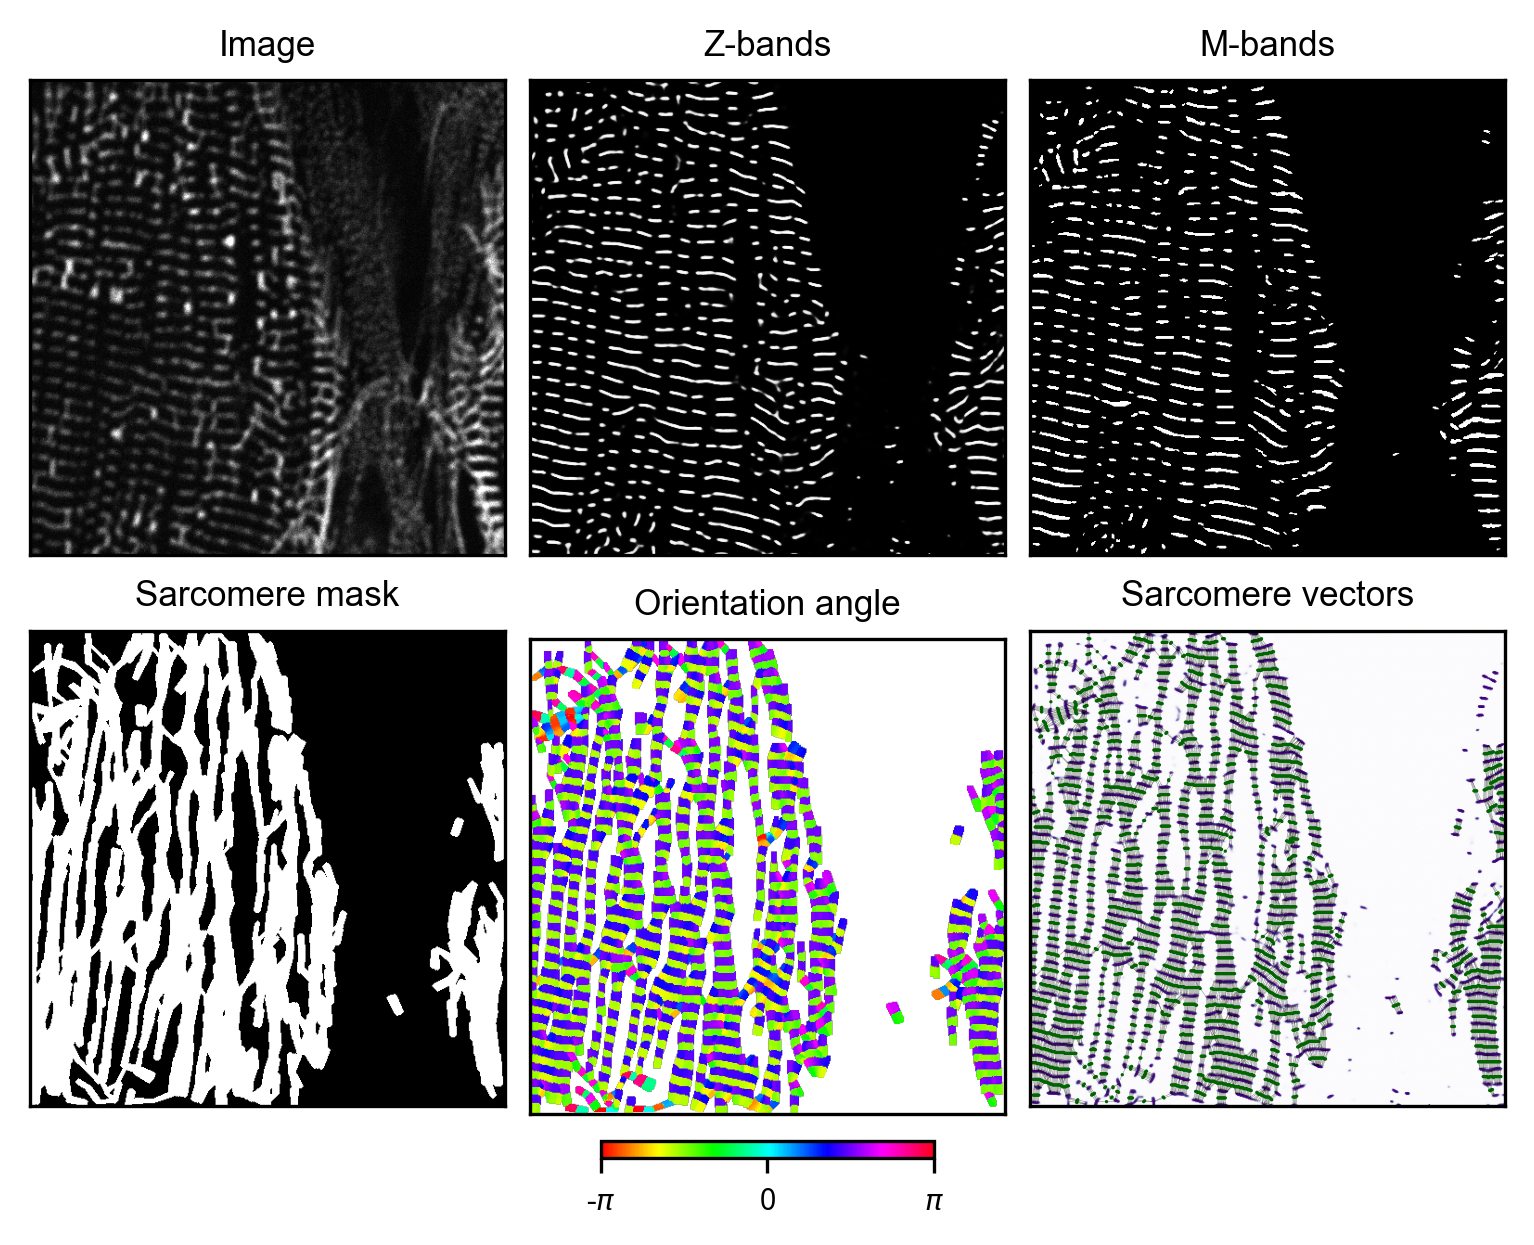

In [154]:
# plot result for image i -> iteratively refine M-band mask for optimal output

generator_i.plot_results()